# Segmentação de imagens utilizando CNN

Nesta aula, utilizaremos modelos de CNN pré-treinadas para segmentar imagens de melanoma. As Redes escolhidas são Unet e Linknet encontradas no site: https://github.com/qubvel/segmentation_models

In [5]:
# !pip install -U -q segmentation-models
# !pip install -q tensorflow==2.2.1
# !pip install -q keras==2.5

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

2023-12-11 13:54:05.676524: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 13:54:05.743242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 13:54:05.743277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 13:54:05.748360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 13:54:05.761930: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 13:54:05.762953: I tensorflow/core/platform/cpu_feature_guard.cc:1

Segmentation Models: using `tf.keras` framework.


In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.io import imread, imread_collection, imsave
#from scipy.misc import imsave as save
from skimage.filters import median,threshold_otsu
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os

**PARÂMETROS**

In [10]:
########################## PARAMETROS ##########################

#QUAL GPU VOCÊ QUER USAR?
GPU_GLOBAL = 0

#QUAL A BASE? (0-ph2, 1-dermis, 2-isic2018)
base_escolhida = 0

# PASTA DOS TESTES
PASTA_DE_TESTES = 'TESTES/base'+str(base_escolhida)+'/'

if not os.path.exists(PASTA_DE_TESTES):
    os.makedirs(PASTA_DE_TESTES)
    
BATCH_SIZE_GLOBAL = 48
NUMERO_EPOCAS_GLOBAL = 50
###############################################################

**ESCOLHA DA BASE DE IMAGENS**

In [11]:
def escolhe_base(base_escolhida):
    if base_escolhida == 0:
        # ph2
        imagens = imread_collection('IMAGENS/PH2PROPORCIONAL128/imagens/*')
        mascaras_medico = imread_collection('IMAGENS/PH2PROPORCIONAL128/mascaras/*')
    elif base_escolhida == 1:
        melanoma_imagens = imread_collection('IMAGENS/DERMIS128/melanoma/*orig*')
        melanoma_mascaras_medico = imread_collection('IMAGENS/DERMIS128/melanoma/*contour*')

        notmelanoma_imagens = imread_collection('IMAGENS/DERMIS128/notmelanoma/*orig*')
        notmelanoma_mascaras_medico = imread_collection('IMAGENS/DERMIS128/notmelanoma/*contour*')

        imagens = np.concatenate((melanoma_imagens, notmelanoma_imagens), axis=0)
        mascaras_medico = np.concatenate((melanoma_mascaras_medico, notmelanoma_mascaras_medico), axis=0)
    elif base_escolhida == 2:
        melanoma_imagens = imread_collection('IMAGENS/ISIC2018-128/MELANOMA/*')
        melanoma_mascaras_medico = imread_collection('IMAGENS/ISIC2018-128/MASKMELANOMA/*')

        notmelanoma_imagens = imread_collection('IMAGENS/ISIC2018-128/NMELANOMA/*')
        notmelanoma_mascaras_medico = imread_collection('IMAGENS/ISIC2018-128/MASKNMELANOMA/*')

        imagens = np.concatenate((melanoma_imagens, notmelanoma_imagens), axis=0)
        mascaras_medico = np.concatenate((melanoma_mascaras_medico, notmelanoma_mascaras_medico), axis=0)
    else:
        print(" Escolha uma base de imagens")
        
    
    return np.array(imagens), np.array(mascaras_medico)

In [12]:
# ESCOLHER BASE
imagens, mascaras_medico = escolhe_base(base_escolhida)

Text(0.5, 1.0, 'Mascara do médico')

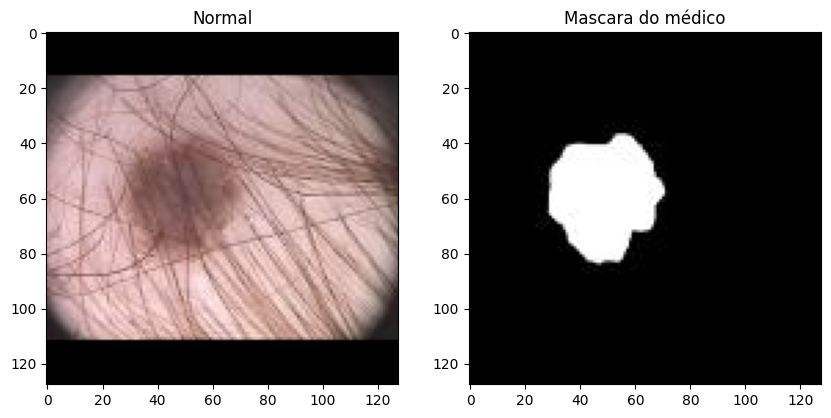

In [13]:
n_imagem = 1

fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex=True)
ax[0].imshow(imagens[n_imagem],cmap = 'gray')
ax[0].set_title('Normal')
ax[1].imshow(mascaras_medico[n_imagem],cmap = 'gray')
ax[1].set_title('Mascara do médico')

**CALCULO DAS METRICAS**

In [14]:
def calc_metric(y_true,y_pred):
    
    #padronizando o y_test
    y_true = np.expand_dims(y_true,axis=-1)
    y_true = np.int64(y_true)
    
    cm = confusion_matrix(y_true.ravel(),y_pred.ravel())
    tn, fp, fn, tp = cm.ravel()
    return calc_metrics_matrix(tn, fp, fn, tp)

def calc_metrics_matrix(tn, fp, fn, tp):
    dice = (2.0 * tp) / ((2.0 * tp) + fp + fn)
    jaccard = (1.0 * tp) / (tp + fp + fn) 
    sensitivity = (1.0 * tp) / (tp + fn)
    specificity = (1.0 * tn) / (tn + fp)
    accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn)
    auc = 1 - 0.5 * (((1.0 * fp) / (fp + tn)) + ((1.0 * fn) / (fn + tp)))
    prec = float(tp)/float(tp + fp)
    fscore = float(2*tp)/float(2*tp + fp + fn)

    return sensitivity,specificity,accuracy,auc,dice,jaccard

In [15]:
# #################### RODAR COM A GPU ##################### (comentar tudo caso der erro)
# gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.experimental.set_visible_devices(gpus[GPU_GLOBAL], 'XLA_GPU')
#     except RuntimeError as e:
#         # Visible devices must be set at program startup
#         print(e)
# print(gpus)

**DIVISÃO DE TREINO/TESTE**

In [16]:
###### dividir o teste, tem validação e teste
x_train, x_val, y_train, y_val = train_test_split(imagens, mascaras_medico, test_size = 0.4, random_state = 11)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size = 0.5, random_state = 12)


x_train= np.asarray(x_train)
y_train= (np.asarray(y_train)> threshold_otsu(np.asarray(y_train)))
x_val= np.asarray(x_val)
y_val= (np.asarray(y_val)>threshold_otsu(np.asarray(y_val)))
x_test= np.asarray(x_test)
y_test= (np.asarray(y_test)>threshold_otsu(np.asarray(y_test)))

y_train = y_train.reshape(-1, 128, 128, 1).astype('float32') 
y_val = y_val.reshape(-1, 128, 128, 1).astype('float32') 
y_test = y_test.reshape(-1, 128, 128, 1).astype('float32') 

# UNET

In [17]:
###### CRIANDO O MODELO UNET
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

unet = sm.Unet(BACKBONE, encoder_weights='imagenet')
unet.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(str(PASTA_DE_TESTES)+'best_model_unet.h5', save_weights_only=True, save_best_only=True, mode='min'),
]

unet.fit(
   x=x_train,
   y=y_train,
   batch_size=BATCH_SIZE_GLOBAL,
   epochs=NUMERO_EPOCAS_GLOBAL,
    callbacks=callbacks,
   validation_data=(x_val, y_val),
)

Epoch 1/50
3/3 [==============================] - 38s 9s/step - loss: 1.2742 - iou_score: 0.2837 - val_loss: 7.5752 - val_iou_score: 0.2036
Epoch 2/50
3/3 [==============================] - 31s 9s/step - loss: 0.8879 - iou_score: 0.4432 - val_loss: 17.0575 - val_iou_score: 0.2007
Epoch 3/50
3/3 [==============================] - 24s 8s/step - loss: 0.6502 - iou_score: 0.5642 - val_loss: 27.8972 - val_iou_score: 0.2002
Epoch 4/50
3/3 [==============================] - 24s 8s/step - loss: 0.5075 - iou_score: 0.6541 - val_loss: 34.4646 - val_iou_score: 0.2001
Epoch 5/50
3/3 [==============================] - 23s 7s/step - loss: 0.4565 - iou_score: 0.6949 - val_loss: 48.8753 - val_iou_score: 0.2000
Epoch 6/50
3/3 [==============================] - 27s 8s/step - loss: 0.3932 - iou_score: 0.7244 - val_loss: 45.9420 - val_iou_score: 0.2003
Epoch 7/50
3/3 [==============================] - 24s 8s/step - loss: 0.3484 - iou_score: 0.7591 - val_loss: 42.2298 - val_iou_score: 0.2007
Epoch 8/50
3/3

**CARREGAR MELHOR MODELO**

In [57]:
# unet.load_weights('TESTES/base0/best_model_unet.h5')

**REALIZAR PREDIÇÃO**

In [19]:
predicoes_unet = unet.predict(imagens)
predicoes_unet= (np.asarray(predicoes_unet)> threshold_otsu(np.asarray(predicoes_unet)))

7/7 [==============================] - 8s 955ms/step


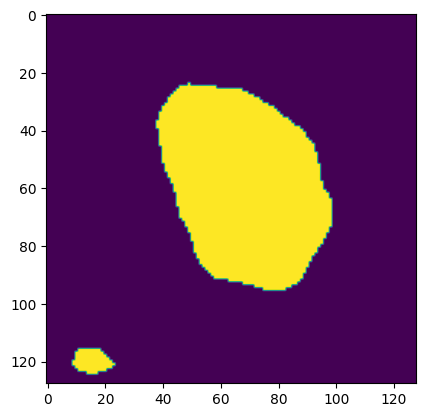

In [40]:
plt.imshow(predicoes_unet[20,:,:,0])

# Linknet

In [21]:
###### CRIA O MODELO LINKNET
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

linknet = sm.Linknet(BACKBONE, encoder_weights='imagenet')
linknet.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(str(PASTA_DE_TESTES)+'best_model_linknet.h5', save_weights_only=True, save_best_only=True, mode='min'),
]

linknet.fit(
   x=x_train,
   y=y_train,
   batch_size=BATCH_SIZE_GLOBAL,
   epochs=NUMERO_EPOCAS_GLOBAL,
    callbacks=callbacks,
   validation_data=(x_val, y_val),
)

Epoch 1/50
3/3 [==============================] - 28s 5s/step - loss: 1.4601 - iou_score: 0.2133 - val_loss: 2.4050 - val_iou_score: 0.2201
Epoch 2/50
3/3 [==============================] - 16s 5s/step - loss: 1.2561 - iou_score: 0.2703 - val_loss: 4.8111 - val_iou_score: 0.2068
Epoch 3/50
3/3 [==============================] - 15s 5s/step - loss: 1.0933 - iou_score: 0.3345 - val_loss: 8.1769 - val_iou_score: 0.2031
Epoch 4/50
3/3 [==============================] - 16s 5s/step - loss: 0.9210 - iou_score: 0.4103 - val_loss: 8.1157 - val_iou_score: 0.2036
Epoch 5/50
3/3 [==============================] - 18s 5s/step - loss: 0.7839 - iou_score: 0.4799 - val_loss: 7.2654 - val_iou_score: 0.2049
Epoch 6/50
3/3 [==============================] - 17s 6s/step - loss: 0.6648 - iou_score: 0.5521 - val_loss: 6.8083 - val_iou_score: 0.2069
Epoch 7/50
3/3 [==============================] - 16s 5s/step - loss: 0.5674 - iou_score: 0.6117 - val_loss: 7.2058 - val_iou_score: 0.2074
Epoch 8/50
3/3 [====

**CARREGAR MELHOR MODELO**

In [56]:
# linknet.load_weights('TESTES/base0/best_model_linknet.h5')

**REALIZAR PREDIÇÃO**

In [23]:
predicoes_linknet = linknet.predict(imagens)
predicoes_linknet= (np.asarray(predicoes_linknet)> threshold_otsu(np.asarray(predicoes_linknet)))

# # calcular metricas do teste
# sensitivity,specificity,accuracy,auc,dice,jaccard = calc_metric(y_test,predicoes[:,:,:,0])
# print("dice ", dice)

7/7 [==============================] - 6s 704ms/step


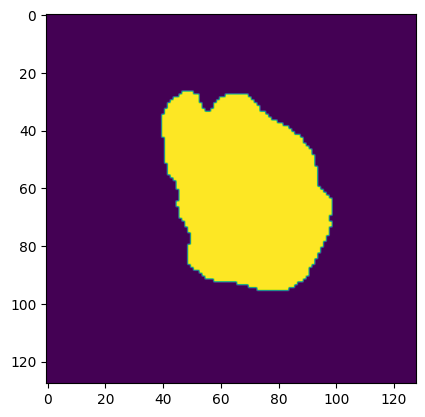

In [41]:
plt.imshow(predicoes_linknet[20,:,:,0])

## DESENHANDO AS SEGMENTAÇÕES NA IMAGEM ORIGINAL

In [28]:
# !pip install opencv-python

In [29]:
import numpy as np
import cv2

def desenhaSegmentacao(image,mask_medical,mask_unet,mask_linknet):
    contours, _ = cv2.findContours(mask_medical, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image,contours, -1, (0,255,0), 1)

    contours, _ = cv2.findContours(mask_unet, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image,contours, -1, (255,0,0), 1)
    
    contours, _ = cv2.findContours(mask_linknet, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image,contours, -1, (0,0,255), 1)
    
    return image

In [30]:
n_img = 20
image = x_test[n_img]
mask_medical = np.uint8(y_test[n_img,:,:,0]) 
mask_unet = np.uint8(predicoes_unet[n_img,:,:,0])
mask_linknet = np.uint8(predicoes_linknet[n_img,:,:,0])

imgdesenhada = desenhaSegmentacao(image,mask_medical,mask_unet,mask_linknet)

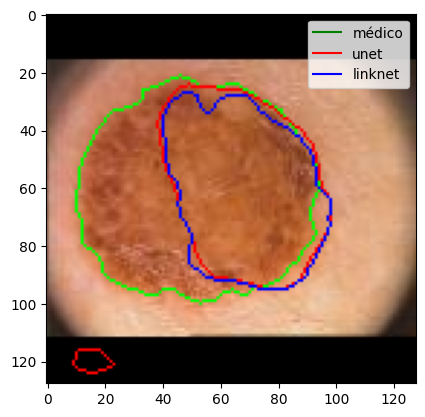

In [54]:
plt.imshow(imgdesenhada)

# legenda
plt.plot([], "-g", label="médico")  
plt.plot([], "-r", label="unet")    
plt.plot([], "-b", label="linknet")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Predição linknet')

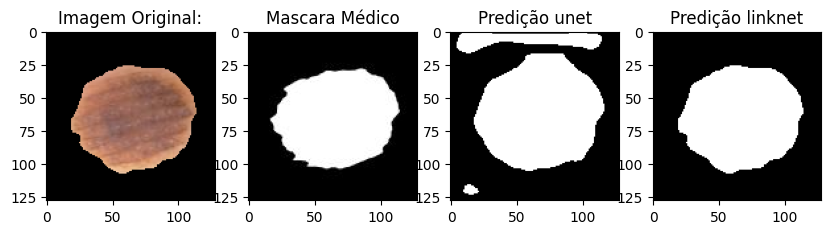

In [55]:
n_img = 125
image = imagens[n_img]
mask_medical = mascaras_medico[n_img]
mask_unet = predicoes_unet[n_img,:,:,0]
mask_linknet = predicoes_linknet[n_img,:,:,0]

fig, ax = plt.subplots(1,4,figsize=(10, 10),sharex=True)
ax[0].imshow(image)
ax[0].set_title('Imagem Original:')
ax[1].imshow(mask_medical, cmap="gray")
ax[1].set_title('Mascara Médico')
ax[2].imshow(mask_unet, cmap="gray")
ax[2].set_title('Predição unet')
ax[3].imshow(mask_linknet, cmap="gray")
ax[3].set_title('Predição linknet')

## Aplicando a segmentação na imagem original

In [36]:
# FUNÇÃO QUE APLICA SEGMENTAÇÃO
def aplicaSegmentacao(img,mask):
    # percorre os 3 canais
    for canal in range(img.shape[2]):
        # aplica a mascara em cada canal
        img[:,:,canal] = img[:,:,canal] * mask
    
    return img 

In [37]:
imagem_segmentada = aplicaSegmentacao(image,mask_linknet)

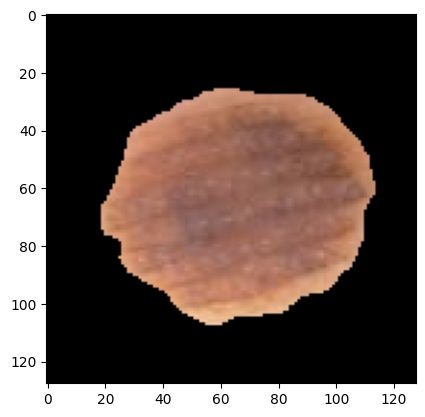

In [39]:
plt.imshow(imagem_segmentada)

**Salvando a imagem segmentada**

In [38]:
from skimage.io import imsave
imsave('imagem_segmentada.png',imagem_segmentada)